## Unsupervised clustering for identifying spatial inhomogeneity on local electronic structures
Hideaki Iwasawa, Tetsuro Ueno, Takahiko Masui, Setsuko Tajima

Correspondence should be addressed to H.I. (iwasawa.hideaki@qst.go.jp)

# Part 2-1: k-means clustering

- Module Setting


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time

- Load iEDCs or iADCs, if you prepared in "Part 1" in advance
- Select and run only one of two (target map will be updated by the last run)

In [2]:
%store -r xpos
%store -r ypos

In [3]:
%store -r iEDCs
%store -r eng
targetMap = iEDCs
slice_axis = eng
slice_dir = 'iEDC'
xaxislabel = 'Binding energy (eV)'
sn = np.shape(eng)[0]

In [4]:
%store -r iADCs
%store -r ang
targetMap = iADCs
slice_axis = ang
slice_dir = 'iADC'
xaxislabel = 'Detector angle (deg)'
sn = np.shape(ang)[0]

## (2-1-i) KM clustering

- Number of clusters (n<sub>k</sub>) can be arranged as you want

In [4]:
nk = 10

- Main Body

In [5]:
t1 = time.time() 

km = KMeans(n_clusters=nk, n_init=10, random_state=100)
km_model = km.fit(targetMap)
km_results = km_model.labels_
pn = len(km_results) 

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

Elapsed Time:  0.8073451519012451


## (2-1-ii) Spatial Distribution of clusters

- Plotting

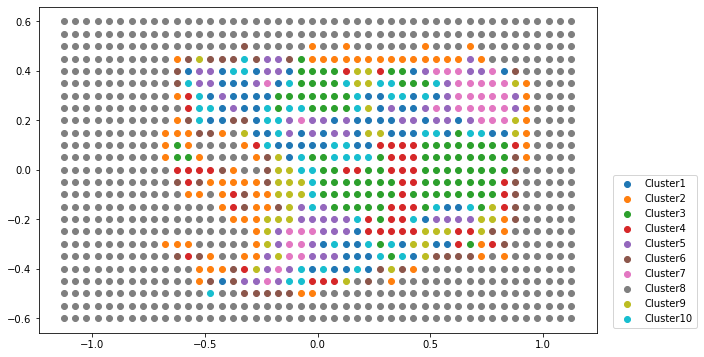

Elapsed Time:  0.27964305877685547


In [6]:
t1 = time.time()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
    
for i in range(nk):
    x = []
    y = []
    for j in range(pn):
        curcln = km_results[j]
        if i == curcln:
            x = np.append(x, xpos[j])
            y = np.append(y, ypos[j])
        if j == pn-1:
            ax.scatter(x, y, marker='o', label="Cluster"+str(i+1))
            globals()[f"km_xpos{i+1}"] = x # For output
            globals()[f"km_ypos{i+1}"] = y # For output
plt.legend(bbox_to_anchor=(1.02, 0.0), loc='lower left')
plt.show()

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

## (2-1-iii) Integrated EDC/ADC within each cluster

- Main Body & plotting

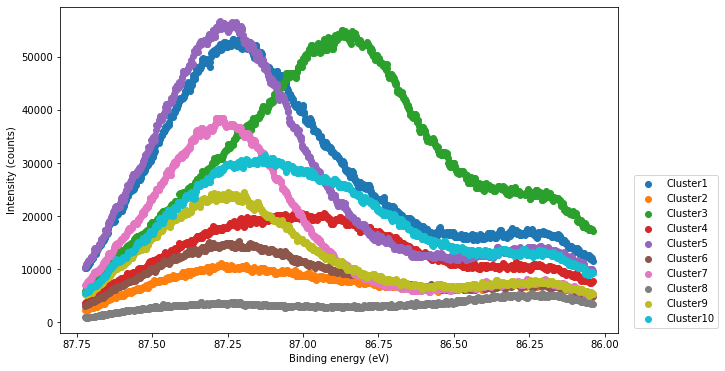

Elapsed Time:  0.26629137992858887


In [7]:
t1 = time.time() 

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, xlabel=xaxislabel, ylabel='Intensity (counts)')

intSlices = np.zeros((nk, sn))

for i in range(nk):
    # Initialization for each cluster number 
    curslice = np.zeros(sn) # 1D y wave
    for j in range(pn):
        curcln = km_results[j]
        if i == curcln:
            curslice += targetMap[j]
        if j == pn-1:
            # First and Last data point is replaced by NaN because of artifactual rapid intesity drop reflecting both edges of the detector
            curslice[0] = np.nan; curslice[sn-1] = np.nan
            intSlices[i][:] = curslice # for saving
            ax.scatter(slice_axis, curslice, marker='o', label="Cluster"+str(i+1))
ax.invert_xaxis()
ax.legend(bbox_to_anchor=(1.02, 0.0), loc='lower left')
plt.show()

t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

## (2-1-iv) Integrated ARPES image within each cluster

- Access 4D data & module setting for that 

In [8]:
from nexusformat.nexus import *
import math
%store -r path2file
%store -r en
%store -r an
%store -r xn
%store -r yn
%store -r eng
%store -r ang

alldata = nxload(path2file) # All data including metadata
mapdata = alldata.entry1.instrument.analyser.data # Spatial Mapping Data (4D)

eng_ini = eng[0]
eng_end = eng[en-1]
ang_ini = ang[0]
ang_end = ang[an-1]

- Main Body

In [9]:
t1 = time.time()

iARPESs = np.zeros((nk, an, en))

for i in range(pn):
    curcln = km_results[i]
    curRow = math.floor(i/yn)
    curCol = i % yn
    iARPESs[curcln][:][:] += mapdata[curRow][curCol][:][:].nxvalue
        
t2 = time.time()
elapsed_time = t2-t1
print('Elapsed Time: ', elapsed_time)

Elapsed Time:  165.9062421321869


- Plotting

In [10]:
# Define number of row and columns for display
n_col = 5 # Set to adjust your screen
n_row = math.ceil(nk/n_col)

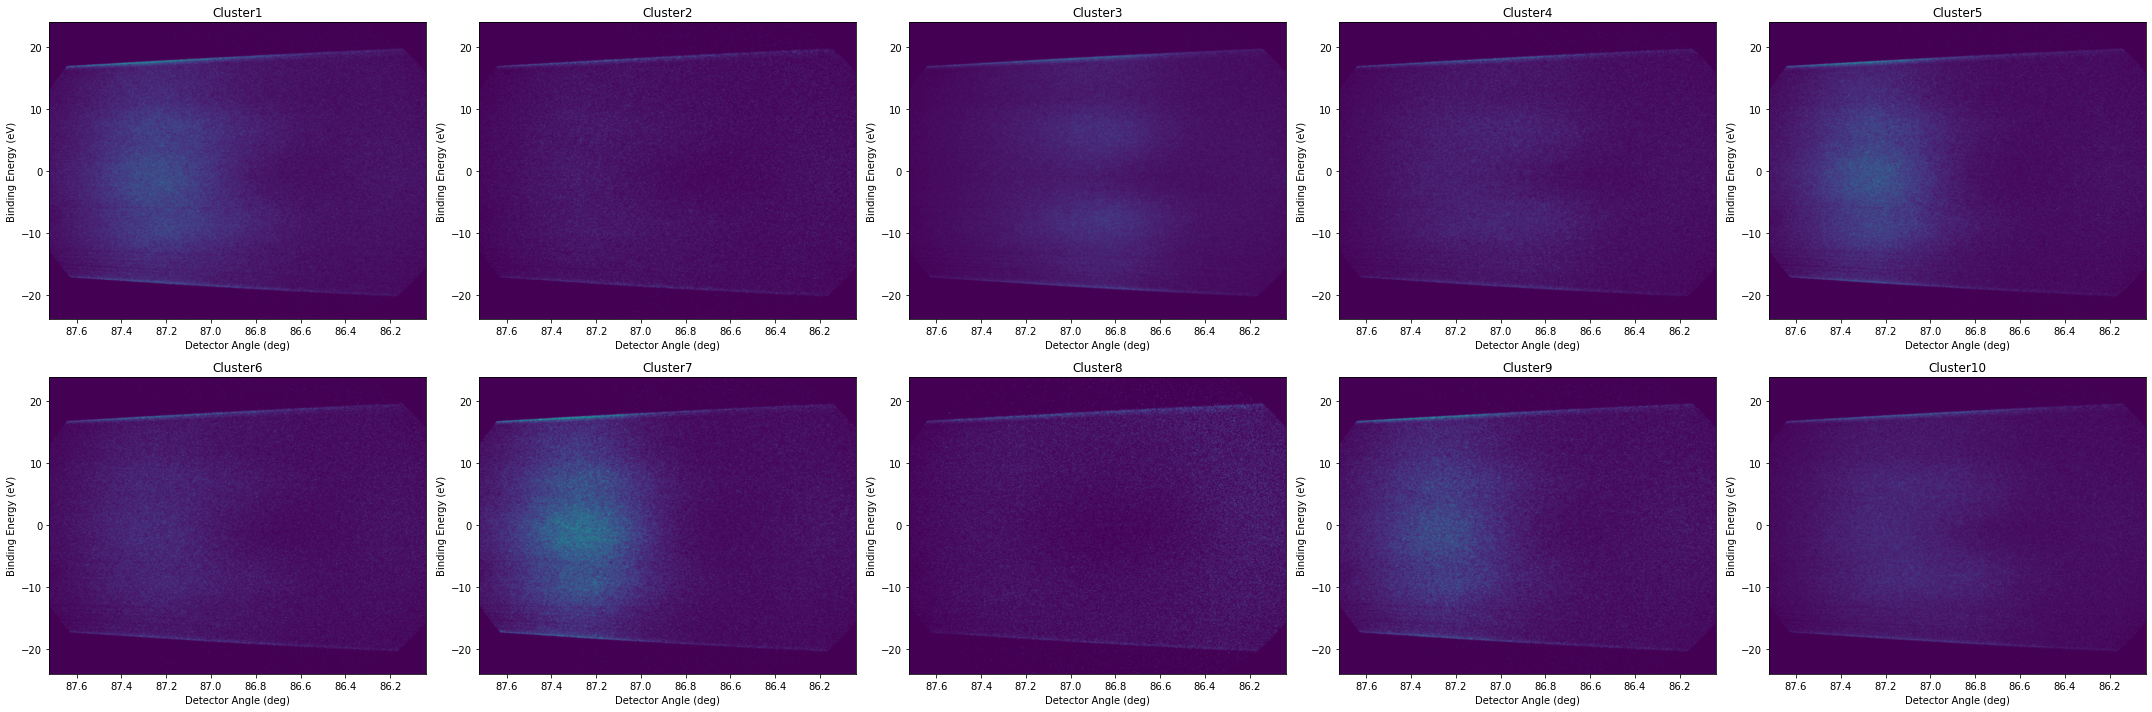

In [11]:
fig = plt.figure(figsize=(6*n_col, 5*n_row))

for i in range(nk):
    iARPES = np.zeros((an, en))
    iARPES = iARPESs[i]
    curax = fig.add_subplot(n_row, n_col, i+1, xlabel='Detector Angle (deg)', ylabel='Binding Energy (eV)')
    curax.set_title("Cluster"+str(i+1))
    #axes.append(fig.add_subplot(1, nk, i+1, ylabel='Detector Angle (deg)', xlabel='Binding Energy (eV)'))
    #axes[-1].set_title("Cluster"+str(i+1))
    plt.imshow(iARPES, aspect="auto", extent= [eng_ini, eng_end, ang_ini, ang_end])
fig.tight_layout()
plt.show()

## (2-1-v) Output

- Save Directory

In [12]:
# default is to create "out" folder in the current directory, if not exist
import os
savedir = './out/'
if os.path.isdir(savedir) == False:
    os.mkdir(savedir)

- Spatial distribution of clusters

In [13]:
for i in range(nk):
    cx = globals()[f"km_xpos{i+1}"]
    cy = globals()[f"km_ypos{i+1}"]
    np.savetxt(savedir+'km_xpos_k'+str(i+1)+'nk'+str(nk)+'.txt', cx, delimiter='\r\n')
    np.savetxt(savedir+'km_ypos_k'+str(i+1)+'nk'+str(nk)+'.txt', cy, delimiter='\r\n')

- Integrated EDCs / ADCs

In [14]:
for i in range(nk):
    curslice = intSlices[i][:]
    np.savetxt(savedir+'km_'+slice_dir+'_k'+str(i+1)+'nk'+str(nk)+'.txt', curslice, delimiter='\r\n')
    np.savetxt(savedir+'xkm_'+slice_dir+'_k'+str(i+1)+'nk'+str(nk)+'.txt', slice_axis, delimiter='\r\n')

- Integrated ARPES image

In [15]:
for i in range(nk):
    iARPES = iARPESs[i][:][:]
    np.savetxt(savedir+'km_iARPES_k'+str(i+1)+'nk'+str(nk)+'.txt', iARPES, delimiter='\t')